In [99]:
# Import library
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import matplotlib.patches as mpatches




In [100]:
# Load data
data = np.loadtxt("seeds_dataset.txt").transpose()

X = data[:7, :] # [7, N]
Y = data[7, :] # [N]
print(f"Number of samples: {data.shape[1]}")

Number of samples: 210


In [101]:
# PCA
def pca_reduce(X, K):
    # X: [D, N]
    _, N = X.shape
    miu = X.mean(axis=1, keepdims=True)
    cov = 1/N * (X - miu) @ (X - miu).transpose()
    U, S, _ = np.linalg.svd(cov)
    U = U[:, :K]

    return U.transpose() @ (X - miu), S


# Obtain PCA for training and testing set
K = 2
X, S = pca_reduce(X, K)
print(f"Eigenvalues are:\n {S}")
print(f"Subspace dimensions: {K}")



# Normalize to 0-1
min_val = X.min(1, keepdims=True)
max_val = X.max(1, keepdims=True)
X = (X - min_val) / (max_val - min_val)



Eigenvalues are:
 [1.07419301e+01 2.11931485e+00 7.32794138e-02 1.28261257e-02
 2.73513989e-03 1.56297146e-03 2.95142261e-05]
Subspace dimensions: 2


In [102]:
# K-means
class k_means:
    def __init__(self, init_centriods):
        self.centroids = init_centriods.copy() # [K, C]
        self.K, self.C = self.centroids.shape
        self.show_colors = ["y", "g", "b"]

    def calc_dist(self, X):
        # X: [K, N]
        # centriods: [K, C]
        K, N = X.shape
        _, C =self.centroids.shape
        X = X[:, :, np.newaxis]
        X = np.tile(X, (1, 1, C)) # [K, N, C]
        centroids = np.tile(self.centroids[:, np.newaxis, :], (1, N, 1)) # [K, N, C]
        dist = np.linalg.norm(X - centroids, axis=0) # [N, C]
        return dist
    


    def infer(self, X):
        dist = self.calc_dist(X)
        return np.argmin(dist, axis=1) + 1
    


    def fit(self, X):
        self.X = X
        prev_centroid = np.full(self.centroids.shape, -1)
        K, N = X.shape # [K, N]
        _, C = self.centroids.shape # [K, C]

        iter = 0
        while (np.any(prev_centroid != self.centroids)):
            # Copy last centroid
            prev_centroid = self.centroids.copy()


            # Update assignment
            r = self.infer(X) # [N]


            # Update centriods
            for i in range(0, C):
                idx = (r == (i+1))
                self.centroids[:, i] = X[:, idx].mean(axis=1)
            iter += 1



        print(f"After {iter} iterations, k-means converge")
        

    
    

    def silhouette_coefficient(self, X):
        # X: [K, N] 
        K,N = X.shape
        dist = self.calc_dist(X) #[N, C]
        first_idx = np.argmin(dist, axis=1) #[N]
        dist[np.arange(N), first_idx] = 1e10
        second_idx = np.argmin(dist, axis=1)
        tmp1, tmp2 = np.meshgrid(first_idx, first_idx)
        tmp3, _ = np.meshgrid(second_idx, second_idx)
        first_first = (tmp1 == tmp2).astype(np.int32)
        second_first = (tmp3 == tmp2).astype(np.int32)
        x1 = np.tile(X.transpose()[:, np.newaxis, :], (1, N, 1))
        x2 = np.tile(X.transpose()[np.newaxis, :, :], (N, 1, 1))
        dist_matrix = np.linalg.norm(x1 - x2, axis=-1)

         
        A = (first_first * dist_matrix).sum(axis=1) / (first_first.sum(axis=1) - 1)
        B = (second_first * dist_matrix).sum(axis=1) / (second_first.sum(axis=1))
        res = (B - A) / np.maximum(A, B)


        
        return res.mean()
    

    def rand_idx(self, X, Y):
        K, N = X.shape

        # The i-j entry means whether i,j has the same assignment
        tmp1, tmp2 = np.meshgrid(Y, Y)
        pair = (tmp1 == tmp2)
        pred_Y = self.infer(X)
        tmp1, tmp2 = np.meshgrid(pred_Y, pred_Y)
        pred_pair = (tmp1 == tmp2)

        a = (np.logical_and(pair, pred_pair).sum() - N) / 2
        b = np.logical_and(np.logical_not(pair), np.logical_not(pred_pair)).sum() / 2
        c = np.logical_and(pair, np.logical_not(pred_pair)).sum() / 2
        d = np.logical_and(np.logical_not(pair), pred_pair).sum() / 2
        return (a + b) / (a + b + c + d)
    
    def draw_fit(self):
        fig = plt.figure(figsize=(6, 6))
        plt.title("Clustering visualization")
        plt.legend(handles=[mpatches.Patch(color='yellow', label="Cluster1"), 
                    mpatches.Patch(color='green', label="Cluster2"),
                    mpatches.Patch(color='blue', label="Cluster3")])
        all_idx = self.infer(self.X)
        centriods = self.centroids
        for i in range(1, self.C+1):
            idx = (all_idx == i)
            plt.plot(X[0, idx], X[1, idx], f"{self.show_colors[i-1]}o", markersize=2)
            plt.plot(centriods[0, :], centriods[1, :], f"rx", markersize=8)
        plt.show(fig)
        plt.close()




    
idx = random.sample(range(X.shape[1]), 3)
print(f"Use index {idx} samples to initialize centriods")
model = k_means(X[:, idx])
model.fit(X)

        

Use index [27, 138, 14] samples to initialize centriods
After 6 iterations, k-means converge


In [103]:
# Caclulate metric
sc = model.silhouette_coefficient(X)
ri = model.rand_idx(X, Y)
print(f"The silhouette coefficient of the model is {sc}")
print(f"The rand index of the model is {ri}")

The silhouette coefficient of the model is 0.46046235809126435
The rand index of the model is 0.8833447254499887


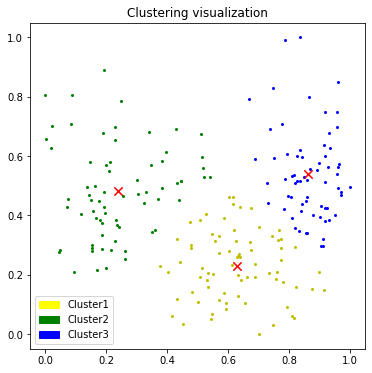

In [104]:
# Draw fitting
model.draw_fit()